# Part 1 - Dimensionality reduction and feature selection


Thinking in higher dimensions is particularly hard. A 1-D dot would hardly be able to imagine a 2D world. In the same way, the square below struggles to think of our 3D world. For us, it is very difficult to imagine dimensions above the 3rd. We have proxies for thinking of the 4th dimension - the passing of time, a 3D surface with some extra measure represented by color, etc - but this starts to become really difficult to work with above the 4th dimension.  

![dimensionality](media/flatland.png)

Thankfully, when dealing with ML problems, you can go above three features without trying to imagine how they would look like (lucky you!). However, you still need to understand how the number of dimensions affects your models and how to work with high dimensional feature spaces. Don't worry, we will guide you through it.

In [1]:
import string
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2

## 1. The curse of dimensionality

So far you learned how to handle text data by transforming it into a vectorized feature space. Namely, we used a few preprocessing tricks and some sort of  word counting to generate our feature space. However, as you might have realized, the number of features for these problems is huge, in particular if you want to cover all language. In the limit, your feature space will cover the entire vocabulary! On top of that, the number of features often exceeds the number of observations.

The effect of high dimensional features in modelling is called the **curse of dimensionality**.

_But I thought "more features" meant "more accuracy"..._

This is not always true. In high dimensional problems, the use of all the features can actually hurt your model.

* More features mean a longer training process.
* You will need way more data points for training and if you can't get them, deal with the effects of having more features than observations.
* Most features won't even be associated with the outcome, just adding complexity to the model.
* Some of the many features will have just chance associations to the outcome which leads to overfitting on the training data, high variance of the solution (a small change in data leads to a large change in the solution), and poor performance on test data.
* This also means that we cannot rely on the training error to measure classifier performance, but only on the test error, ideally measured in cross-validation.
* For linear models, if the number of features exceeds the number of observations, there are infinitely many solutions.
* Interpretability will be difficult.

## 2. Basic feature selection

One of the ways you can reduce the feature number is by performing feature selection. We are going to walk you through some feature selection methods with an example. Let's start by loading the data - we are going to use the Twitter data set of Republican and Democrat tweets.

### 2.1 The data

Start by importing the data set.

In [2]:
df = pd.read_csv('./data/twitter_rep_dem_data_small.csv')
df.head(10)

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...


Check the class balance:

In [3]:
df.Party.value_counts()

Party
Republican    9302
Democrat      9217
Name: count, dtype: int64

Pretty balanced!

You'll notice that the tweets are just text with some particularities. For example, it is common to have Twitter handles in the text, defined by the "@" character. The data has three columns, but we are going to ignore the *Handle* column for now and just focus on classifying *Tweets* with *Party* labels.

### 2.2 Feature extraction

Since you are a great student, you thoroughly studied BLU07 and you already know how to preprocess text and extract some simple features. So let's preprocess our data: remove unnecessary characters, tokenize, lowercase, and vectorize.

First we'll lowercase and apply simple tokenization. To avoid overfitting on Twitter related information, like the handles or hashtags in the messages, we'll remove those, so our focus is only on the language.

In [4]:
hashtag_removal = lambda doc: re.subn(r'#\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(hashtag_removal)

handle_removal = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_removal)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

df.head(10)

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"today , senate dems vote to . proud to support..."
1,Democrat,RepDarrenSoto,rt : winter haven resident / alta vista teache...
2,Democrat,RepDarrenSoto,rt : . noted that hurricane maria has left app...
3,Democrat,RepDarrenSoto,rt : meeting with . thanks for taking the time...
4,Democrat,RepDarrenSoto,rt : hurricane season starts on june 1st ; pue...
5,Democrat,RepDarrenSoto,rt : thank you to all who came out to our orla...
6,Democrat,RepDarrenSoto,hurricane maria left approx $ 90 billion in da...
7,Democrat,RepDarrenSoto,rt : i am delighted that will be voting for th...
8,Democrat,RepDarrenSoto,rt : trump ' s anti - immigrant policies are h...
9,Democrat,RepDarrenSoto,rt : great joining and for a roundtable in on ...


Now we split the data into the train and test set and vectorize it. We'll use a random seed so that the results are replicable.

In [5]:
seed = 42

<img src="media/random.png" width="400">

In [6]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)

print('Training examples: {}'.format(train_data.size))
print('Test examples: {}\n'.format(test_data.size))

# important: only train the vectorizer on the training data
vectorizer = TfidfVectorizer(ngram_range=(1,2))
%timeit vectorizer.fit(train_data.Tweet)

X_train = vectorizer.transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

y_train = train_data.Party
y_test = test_data.Party

Training examples: 38889
Test examples: 16668

1.02 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 2.3 The baseline

Let's get our baseline accuracy and measure the time it takes to fit a Naive Bayes model, a model you should be familiar with and which in NLP comes hand in hand with the Bag Of Words representation (if you don't get the joke below, eventually you should go read more about Naive Bayes).

<img src="./media/frequentists_vs_bayesians_2x.png" width="400">

In [7]:
clf =  MultinomialNB()
%timeit clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

43.5 ms ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7361411087113031


### 2.4 Feature selection

Now that we have the baseline, let's start by looking into the number of features used in the classifier:

In [8]:
X_train.shape

(12963, 131301)

So far we got a good baseline and the classifier even trained pretty fast, but a 130K-dimensional space is obviously very difficult to interpret. Let's try to reduce the number of features by extracting the K most important words. One way to do this is to keep the most frequent words. In fact, the TfidfVectorizer already has an option for that, `max_features`. Let's see the impact on the training speed and accuracy for 10 - 100000 most important features.

In [9]:
for k in [10, 100, 1000, 5000, 10000, 50000, 100000]:
    print('Using {} features'.format(k))
    print('----'.format(k))
    
    X_train = train_data.Tweet
    X_test = test_data.Tweet
    
    vectorizer_truncated = TfidfVectorizer(ngram_range=(1,2), max_features=k)
    vectorizer_truncated.fit(X_train)

    X_train_truncated = vectorizer_truncated.transform(X_train)
    X_test_truncated = vectorizer_truncated.transform(X_test)
    
    clf =  MultinomialNB()
    %timeit clf.fit(X_train_truncated, y_train)
    y_pred = clf.predict(X_test_truncated)
    
    print('Accuracy: {}\n'.format(accuracy_score(y_pred, y_test)))

Using 10 features
----
26.2 ms ± 5.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5257379409647228

Using 100 features
----
24.8 ms ± 719 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5827933765298776

Using 1000 features
----
25.3 ms ± 667 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.6544276457883369

Using 5000 features
----
25.8 ms ± 433 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7041036717062635

Using 10000 features
----
26.2 ms ± 517 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7150827933765299

Using 50000 features
----
29.1 ms ± 815 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7311015118790497

Using 100000 features
----
49 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7339812814974802



Ok, no amazing effects, the accuracy actually drops when we limit the number of features too much. Let's look into the top K-features to see if they make sense.

In [10]:
K=10
vectorizer_truncated = TfidfVectorizer(ngram_range=(1,2), max_features=K)
vectorizer_truncated.fit(X_train)
feature_names = vectorizer_truncated.get_feature_names_out()
for f in feature_names:
    print(f)

and
co
for
https
https co
in
of
rt
the
to


As you can see, the top 10 features are basically meaningless with regard to the classes and look more like stopwords. In the next cell you will see that the counts of these words are balanced between the classes.

In [11]:
for feature in feature_names:
    print('Documents that contain the word "{}"'.format(feature))
    print('----')
    docs = X_train.str.contains(feature)
    print(str(y_train[docs].value_counts()) + '\n\n')

Documents that contain the word "and"
----
Party
Democrat      2351
Republican    2250
Name: count, dtype: int64


Documents that contain the word "co"
----
Party
Democrat      5545
Republican    5482
Name: count, dtype: int64


Documents that contain the word "for"
----
Party
Democrat      2148
Republican    2094
Name: count, dtype: int64


Documents that contain the word "https"
----
Party
Democrat      4818
Republican    4702
Name: count, dtype: int64


Documents that contain the word "https co"
----
Series([], Name: count, dtype: int64)


Documents that contain the word "in"
----
Party
Republican    5060
Democrat      5030
Name: count, dtype: int64


Documents that contain the word "of"
----
Party
Democrat      2262
Republican    2207
Name: count, dtype: int64


Documents that contain the word "rt"
----
Party
Republican    2718
Democrat      2617
Name: count, dtype: int64


Documents that contain the word "the"
----
Party
Democrat      4150
Republican    4119
Name: count, dtype: in

Try to exclude stopwords from the TfidfVectorizer and repeat the analysis to see what new top features you obtain. You will probably see that there will be some common words and some "political discourse" words, but nothing really Democrat/Republican specific. 

Let's move on to better feature selection methods and see if we can select class-specific features.

## 3. Statistical tests for feature selection

Basic feature selection methods might actually sometimes, in particular if you use a reasonable heuristic for choosing the features. In our case, just picking the most frequent words is not that good, since it doesn't guarantee that those words will have some relation to the labels. But you could try to pick words that appear only (or almost only) in one of the classes.

This looks like a good idea, but designing such a heuristic might take a lot of time. This is where hypothesis testing comes into play. You don't have to look for reasons to use particular features, just use a test to get insights into which features are associated with each class.

### 3.1 Hypothesis testing

In hypothesis testing we use statistical tests to answer questions about our data such as: are the means of variables A and B different? Is there some relation between variables C and D? 

The basic setup of hypothesis testing goes like this. We have a default hypothesis called **null hypothesis** which basically says that nothing happens. So the means of variables A and B are not different, they are equal. There is no relation between variables C and D, they are independent.

In the next step we calculate some kind of measure called **statistic** from the variable values. The kind of statistic we choose depends on the null hypothesis. We'll have a different statistic for comparing variable means than for deciding about variable independence. Commonly used statistics are t, F, or chi-squared statistics.

Then we decide if the value of the statistic is what we'd expect in case that the null hypothesis is true. We compare the value we calculated to a **null distribution** which is a distribution of the expected statistic values given that the null hypothesis holds. If our calculated statistic is sufficiently extreme, i.e. it falls sufficiently far from the center of the distribution, we decide that it is very likely that the null hypothesis does not hold and we reject it. In our examples, that would mean that the means of variables A and B are different and that the variables C and D are not independent.

The comparison of the calculated and expected statistic gives us a **p-value** which is a number between 0 and 1, also commonly expressed in percentage points. The p-value expresses how likely it is to obtain a value of the statistic that we measured given that the null hypothesis holds. For example, a p-value of 0.05 means that if we repeat the test many times, we'd get a value of the statistic this or more extreme in 5% of cases. If the p-value is small enough, we decide to reject the null hypothesis. Often, null hypothesis is rejected if the p-value is smaller than 0.05 or 0.01, but it depends on the application.

### 3.2 The chi-squared test
For the purpose of feature selection, we'd like to know which features have some relation to the class labels, i.e. which features are not independent from the labels. That means that some features (words) would appear more often in Republican tweets and others in Democrat tweets. The null hypothesis is that the feature and class labels are independent.

For testing variable independence, we use the **chi-squared** statistic which is calculated as follows

$$\chi^2 = \sum{\frac{(O_{x_1x_2} - E_{x_1x_2})^2}{E_{x_1x_2}}}$$

where $O_{x_1x_2}$ is the measured conjunction of the variables $x_1$ and $x_2$ and $E_{x_1x_2}$ is the expected value of the conjuction for the case of the null hypothesis, so independent variables. Basically, we are comparing the distribution of the given feature between the classes. If the feature and the labels are independent, we'd expect that word to be equally distributed between Republican and Democrat tweets. If the feature and the labels are dependent, we'll get an unequal distribution. We'll go through an example calculation below.

A higher value of $\chi^2$ means that the null hypothesis is less likely to hold and results in a lower p-value.

### 3.3 Example calculation for chi-squared
Let's do a really quick example for you to understand how this works. Let's say we are modeling how the characteristics of Star Trek characters are related to their death. We have one particular feature called "has red t-shirt" which can take only two categorical values: Yes/No.

Let's build a table representing this scenario:

|  Has red t-shirt    | Dies   | Does not die | Total |
|----------------------|--------|--------------|-------|
|         Yes          |   63   |      9       |  72   |
|         No           |   13   |     40       |  53   |
|         total        |   76   |     49       |  125  |

This is what we call a **contigency table**, and it contains our observed values.

The null hypothesis is that the variables are independent, i.e. the probability to die is the same regardless of the t-shirt color. The expected values of the probability to die is $N*P(x_1x_2) = N*P(x_1)P(x_2)$. Using the number of dead/living characters and red/other t-shirt we have, we get:

|  Has red t-shirt    | Dies   | Does not die | 
|----------------------|--------|--------------|
|         Yes          |  43.78 $$(125 * \frac{76}{125}\frac{72}{125})$$ | 28.22 $$(125 * \frac{49}{125}\frac{72}{125})$$ |
|         No           |  32.22 $$(125 * \frac{76}{125}\frac{53}{125})$$ | 20.78 $$(125 * \frac{49}{125}\frac{53}{125})$$ |

Now we can use the observed and expected values to compute the chi-squared statistic using the formula $\chi^2 = \sum{\frac{(O_{x_1x_2} - E_{x_1x_2})^2}{E_{x_1x_2}}}$

|  Has red t-shirt    | Dies   | Does not die | 
|----------------------|--------|--------------|
|         Yes          |  8.44 $$(\frac{(63-43.78)^2}{43.78})$$ | 13.09 $$(\frac{(9-28.22)^2}{28.22})$$ |
|         No           |  11.47 $$(\frac{(13-32.22)^2}{32.22})$$ | 17.79 $$(\frac{(40-20.78)^2}{20.78})$$ |

Summing up, we get a chi-squared of 50.79. This corresponds to a p-value < .00001, which means that we can be rather sure to reject the null hypothesis and be confident that we are dealing with dependent variables. 

There are methods and even tables to help you find the p-value from a $\chi^2$ value, you can check these references later [\[1\]](https://www.socscistatistics.com/pvalues/chidistribution.aspx), [\[2\]](https://www.youtube.com/watch?v=HwD7ekD5l0g).

<img src="./media/dig3graves.jpeg" width="400">

If you want to see this manual calculation applied to the Twitter data and some more $\chi^2$ math, check out the optional learning notebook.

## 4. Feature selection based on chi-squared

Now we apply the $\chi^2$ test to our data, select the best features and train a model on them. We can use the $\chi^2$ test for any non-negative features.

### 4.1 Set up the problem

Like before, let's fetch our data, extract its features, run a baseline, and move from there.

_Note that this is the same data set we used before and same processing methods, we're just ensuring that you re-run this before moving forward._ 

In [12]:
stat_df = pd.read_csv('./data/twitter_rep_dem_data_small.csv')

stat_df['Tweet'] = stat_df['Tweet'].map(handle_removal)
stat_df['Tweet'] = stat_df['Tweet'].map(hashtag_removal)
stat_df['Tweet'] = stat_df['Tweet'].map(simple_tokenizer)

stat_train_data, stat_test_data = train_test_split(stat_df, test_size=0.3, random_state=seed)

stat_vectorizer = TfidfVectorizer(ngram_range=(1,2))
%timeit stat_vectorizer.fit(stat_train_data.Tweet)

stat_X_train = stat_vectorizer.transform(stat_train_data.Tweet)
stat_X_test = stat_vectorizer.transform(stat_test_data.Tweet)

stat_y_train = stat_train_data.Party
stat_y_test = stat_test_data.Party

stat_clf =  MultinomialNB()
%timeit stat_clf.fit(stat_X_train, stat_y_train)

stat_pred = stat_clf.predict(stat_X_test)

print('Accuracy: {}'.format(accuracy_score(stat_pred, stat_y_test)))

1.22 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.4 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7361411087113031


### 4.2 Select k best features

We will now obtain the $\chi^2$ values for our data. We want to calculate $\chi^2$ for each feature and the labels. The sklearn [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) gives us the $\chi^2$ values and the p-values.

In [13]:
chi_squared, p_values = chi2(stat_X_train, stat_y_train)

We can plot the features with the 30 highest chi-squared values which are more likely to be dependent on the labels.

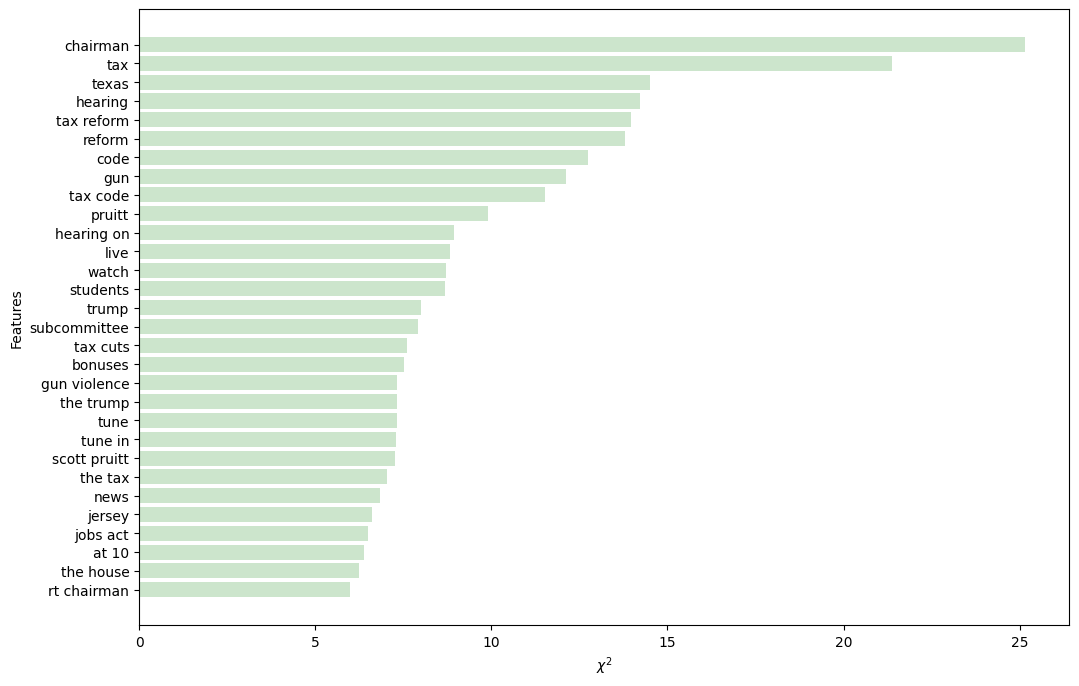

In [14]:
feature_names = stat_vectorizer.get_feature_names_out()
zipped_chi_squared = zip(feature_names, chi_squared)
sorted_chi_squared = sorted(zipped_chi_squared, key=lambda x:x[1]) 
top_chi_squared = list(zip(*sorted_chi_squared[-30:]))

plt.figure(figsize=(12,8))
x = range(len(top_chi_squared[1]))
labels = top_chi_squared[0]
plt.barh(x, list(top_chi_squared)[1], align='center', alpha=.2, color='g')
plt.yticks(x, labels)
plt.xlabel(r'$\chi^2$')
plt.ylabel('Features');

Let's also plot the p-values for these features:

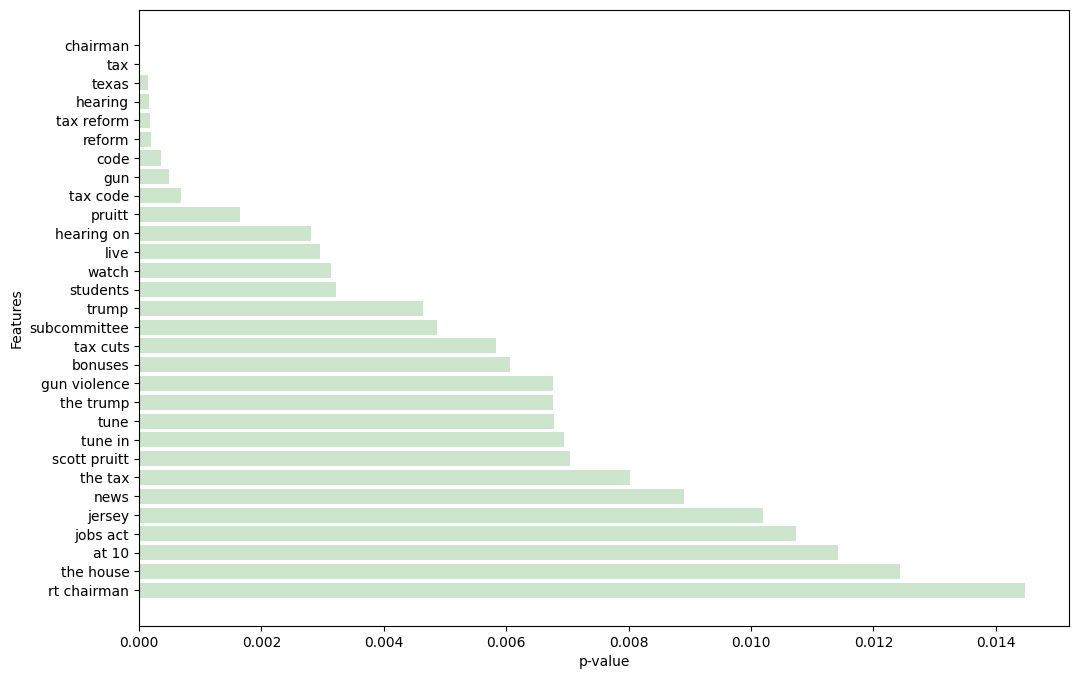

In [15]:
feature_names = stat_vectorizer.get_feature_names_out()
zipped_chi_squared = zip(feature_names, chi_squared)
sorted_chi_squared = sorted(zipped_chi_squared, key=lambda x:x[1])
top_ci_squared = list(zip(*sorted_chi_squared[-30:]))
zipped_p_values = zip(p_values,chi_squared)
sorted_p_values = sorted(zipped_p_values, key=lambda x:x[1])
top_p_values = list(zip(*sorted_p_values[-30:]))

plt.figure(figsize=(12,8))
x = range(len(top_p_values[0]))
labels = top_chi_squared[0]
plt.barh(x, list(top_p_values)[0], align='center', alpha=.2, color='g')
plt.yticks(x, labels)
plt.xlabel('p-value')
plt.ylabel('Features');

They are quite small, so we can confidently says that these features are  dependent on the labels.

Actually, scikit-learn provides a function to directly select the K-best features, [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest). It can perform the selection based on different statistics, also on $\chi^2$. We can confirm that the top selected features match the ones with the highest $\chi^2$ values from above.

Here we select the top 10 features, notice that they are ordered alphabetically and not by $\chi^2$.

In [16]:
ch2 = SelectKBest(chi2, k=10)
ch2.fit(stat_X_train, stat_y_train)

most_important_features = [feature_names[i] for i in ch2.get_support(indices=True)]
for f in most_important_features:
    print(f"'{f}'")

'chairman'
'code'
'gun'
'hearing'
'pruitt'
'reform'
'tax'
'tax code'
'tax reform'
'texas'


Now we're getting somewhere, these new features are starting to make sense. We can look into their distribution in the tweets.

In [17]:
for feature in most_important_features:
    print('Documents that contain the word "{}"'.format(feature))
    print('----')
    docs = stat_train_data['Tweet'].str.contains(feature)
    print(f'Republican | Democrat')
    print(f'{stat_y_train[docs].value_counts().iloc[0]:10} | {stat_y_train[docs].value_counts().iloc[1]} \n') 

Documents that contain the word "chairman"
----
Republican | Democrat
       196 | 8 

Documents that contain the word "code"
----
Republican | Democrat
       105 | 3 

Documents that contain the word "gun"
----
Republican | Democrat
       146 | 17 

Documents that contain the word "hearing"
----
Republican | Democrat
       264 | 62 

Documents that contain the word "pruitt"
----
Republican | Democrat
        86 | 4 

Documents that contain the word "reform"
----
Republican | Democrat
       199 | 28 

Documents that contain the word "tax"
----
Republican | Democrat
       493 | 149 

Documents that contain the word "tax code"
----
Republican | Democrat
        93 | 2 

Documents that contain the word "tax reform"
----
Republican | Democrat
       123 | 6 

Documents that contain the word "texas"
----
Republican | Democrat
       111 | 1 



As you can see, these words are much more common in Republican tweets compared to Democrat tweets. These features are thus much more interpretable and should have a stronger impact on training.

Below we select the k most important features based on $\chi^2$ and train the naive Bayes model on them.

In [18]:
for k in [10, 100, 1000, 5000, 10000, 50000, 100000, 'all']:
    print('Using {} features'.format(k))
    print('----'.format(k))
    
    ch2_train = SelectKBest(chi2, k=k)
    ch2_train.fit(stat_X_train, stat_y_train)
    X_train_chi = ch2_train.transform(stat_X_train)
    X_test_chi = ch2_train.transform(stat_X_test)

    clf = MultinomialNB()
    %timeit clf.fit(X_train_chi, stat_y_train)

    y_pred = clf.predict(X_test_chi)

    print('Accuracy: {}\n'.format(accuracy_score(y_pred, stat_y_test)))

Using 10 features
----
27.8 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5151187904967602

Using 100 features
----
27.5 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.5930525557955364

Using 1000 features
----
27.9 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.6799856011519079

Using 5000 features
----
40.2 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7035637149028078

Using 10000 features
----
41.4 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7102231821454283

Using 50000 features
----
42.2 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.728581713462923

Using 100000 features
----
43.1 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.7356011519078474

Using all features
----
51.4 ms ± 7.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Accuracy: 0.736141108711

We do not get a much higher accuracy than with the basic feature selection, but we get it with less and more meaningful features. 

One thing that feature selection does not take into consideration is feature interaction, which can limit a bit the gains in performance. In the following notebooks, you will learn more elaborate methods to perform dimensionality reduction that deal also with this problem.

## 5. Final remarks

After reading this notebook you should understand:

 - What is the curse of dimensionality
 - How can you perform simple feature selection by reasoning about your problem
 - How to apply statistical methods for feature selection by finding dependencies between features and labels
 
Keep in mind that predicting in the real world is much less theoretical. The performance of these methods will depend a lot on your problem, the size of your dataset, your model, your preprocessing. You can use feature selection to improve speed, avoid overfitting, or even just to better interpret the features and how they interact with the classes.

**Suggestion**: try to vary the following options/parameters and analyze their impact:

- Experiment a bit more with the preprocessing. For example, we haven't removed stopwords when selecting the top features - we suggest you try removing them and check that everything still holds.
- Try other feature extraction options such as the simple CountVectorizer.
- Use smaller slices of the data set to see how the dataset size impacts both baseline and feature selected results.
- Experiment with other classifiers and the impact of the dimensionality reduction on them.
- Try to use the model to evaluate other text data, look around on Kaggle for data sets.

There are other feature selection methods that you might find useful. Some examples of these are:

- Feature selection through variance (sklearn.feature_selection.VarianceThreshold)
- Feature selection through mutual information
- Recursive feature elimination
- Tree-based feature selection

**And remember, these methods just tell us that there is a relation between labels and features, but not the nature of that relation.** Now go and apply these methods!

![correlation](media/correlation.png)